# Notebook 04 — Model Curves and Metrics

This notebook loads saved outputs (hybrid_metrics.json, ROC/PR arrays) and overlays CatBoost (solo) vs Hybrid on val/test splits. It is the go-to place for quick performance readouts and to confirm the evaluation protocol is applied consistently.

## Mathematical overview and metrics

- **Splits**: `val` and `test` come from held-out years; no overlap with training.
- **Curves**: ROC (TPR vs FPR) and PR (Precision vs Recall) summarize classifier ranking quality.
- **AUC / AP**: Area Under ROC and Average Precision; higher is better. We overlay CatBoost alone and the Hybrid blend on the same axes.
- **Hybrid rationale**: Hybrid keeps CatBoost supervised signal and adds residual/AE stress scores as an out-of-distribution check and calibration stabilizer across seasons; even if AUC/AP stay similar, it can flag off-manifold cases and smooth extremes.
- **Files loaded**: `data/interim/hybrid_metrics.json` (scalar metrics) and saved probability arrays for val/test.
- **Plots in this notebook**:
  1) ROC curves (CatBoost vs Hybrid) for val/test with the shared decision threshold marked.
  2) PR curves (CatBoost vs Hybrid) for val/test with the shared decision threshold marked.
  3) Score density by label/model to visualize separation across splits.
  4) Metric table for quick comparison.

Goal: provide a clear, quantitative comparison of CatBoost and the Hybrid model under the fixed evaluation protocol.

# 04 – Model Performance & Ablations

Load metrics/predictions and visualize ROC/PR; optional light ablation on label quantile if available.

In [74]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

sns.set_style("whitegrid")

INTERIM = Path('data/interim')
with open(INTERIM / 'hybrid_metrics.json') as f:
    metrics = json.load(f)

print(json.dumps(metrics, indent=2))

tau = metrics['hybrid']['tau']
splits = ['val', 'test']
models = ['catboost', 'hybrid']

labels = {
    'val': np.load(INTERIM / 'y_val_deficit_label.npy'),
    'test': np.load(INTERIM / 'y_test_deficit_label.npy'),
}

probs = {
    'catboost': {
        'val': np.load(INTERIM / 'catboost_prob_val.npy'),
        'test': np.load(INTERIM / 'catboost_prob_test.npy'),
    },
    'hybrid': {
        'val': np.load(INTERIM / 'hybrid_risk_val.npy'),
        'test': np.load(INTERIM / 'hybrid_risk_test.npy'),
    },
}

{
  "svd": {
    "rank": 1,
    "explained_variance_ratio": [
      0.986250102519989
    ]
  },
  "catboost": {
    "roc_auc_train": 0.9999201022690956,
    "roc_auc_val": 0.9917710196779964,
    "roc_auc_test": 0.9605978260869565,
    "average_precision_val": 0.9936576860789879,
    "average_precision_test": 0.9456646161809206,
    "f1_at_0_5_val": 0.9523809523809523,
    "f1_at_0_5_test": 0.7857142857142857
  },
  "autoencoder": {
    "train_recon_mse": 0.2602612376213074,
    "healthy_train_samples": 168
  },
  "hybrid": {
    "roc_auc_val": 0.9917710196779964,
    "roc_auc_test": 0.9646739130434783,
    "average_precision_val": 0.9948292175389808,
    "average_precision_test": 0.9538909007659008,
    "f1_at_tau_val": 0.9354838709677419,
    "f1_at_tau_test": 0.7407407407407407,
    "tau": 0.3098607361316681,
    "train_f1_at_tau": 0.9966555183946488
  }
}


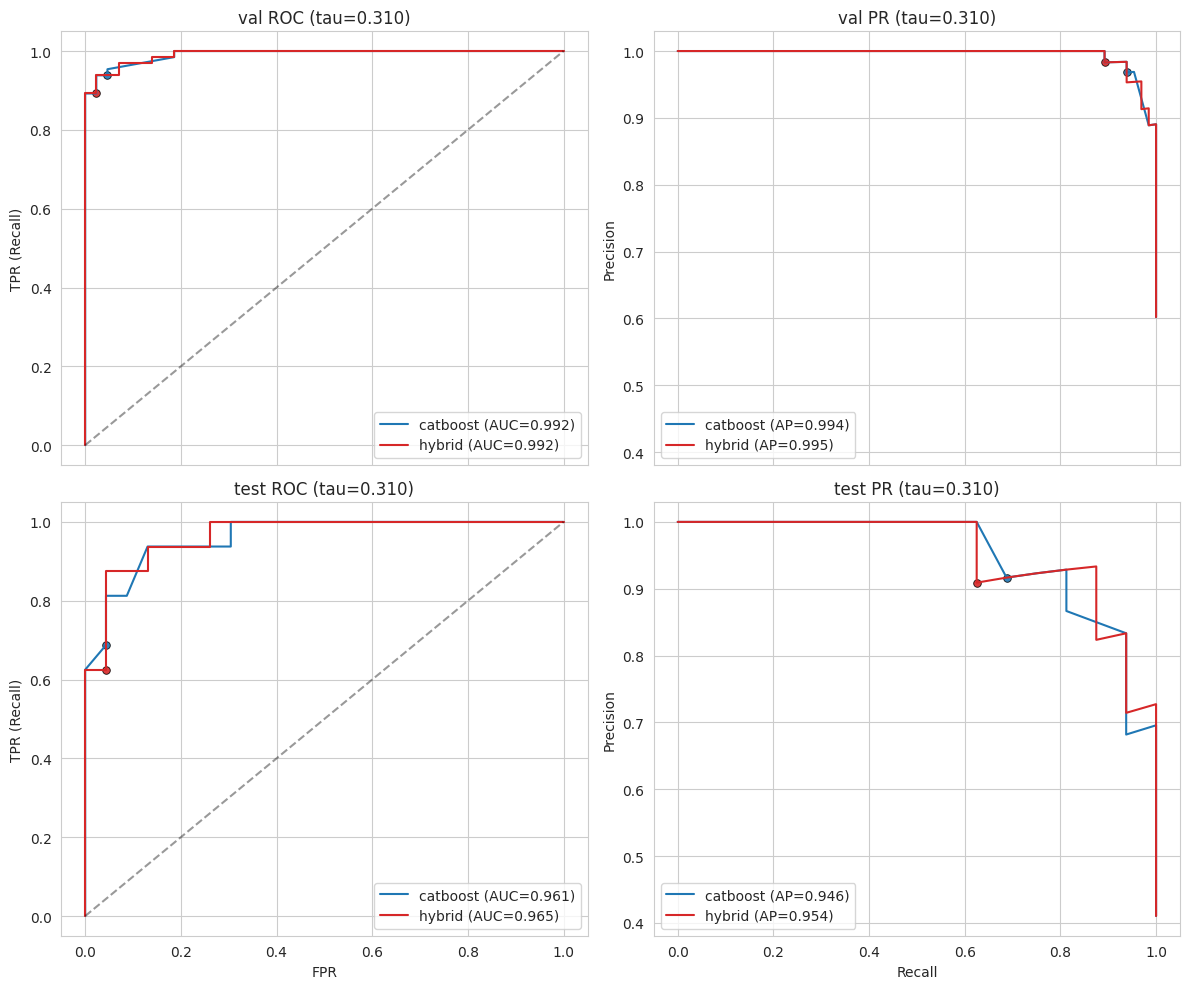

In [75]:
# ROC/PR for val/test (CatBoost and Hybrid on shared axes)
model_colors = {'catboost': '#1f77b4', 'hybrid': '#d62728'}


def operating_point(y_true, scores, tau):
    y_hat = scores >= tau
    tp = np.sum((y_true == 1) & y_hat)
    fp = np.sum((y_true == 0) & y_hat)
    fn = np.sum((y_true == 1) & ~y_hat)
    tn = np.sum((y_true == 0) & ~y_hat)
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tpr
    return fpr, tpr, precision, recall


fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex='col', sharey='col')
for row, split in enumerate(splits):
    y_true = labels[split]
    for model in models:
        scores = probs[model][split]
        fpr, tpr, _ = roc_curve(y_true, scores)
        prec, rec, _ = precision_recall_curve(y_true, scores)
        axes[row, 0].plot(fpr, tpr, label=f"{model} (AUC={auc(fpr, tpr):.3f})", color=model_colors[model])
        axes[row, 1].plot(rec, prec, label=f"{model} (AP={average_precision_score(y_true, scores):.3f})", color=model_colors[model])

        fpr_tau, tpr_tau, prec_tau, rec_tau = operating_point(y_true, scores, tau)
        axes[row, 0].scatter(fpr_tau, tpr_tau, color=model_colors[model], marker='o', s=30, edgecolor='k', linewidth=0.6, alpha=0.9)
        axes[row, 1].scatter(rec_tau, prec_tau, color=model_colors[model], marker='o', s=30, edgecolor='k', linewidth=0.6, alpha=0.9)

    axes[row, 0].plot([0, 1], [0, 1], 'k--', alpha=0.4)
    axes[row, 0].set_title(f"{split} ROC (tau={tau:.3f})")
    axes[row, 1].set_title(f"{split} PR (tau={tau:.3f})")
    axes[row, 0].set_ylabel('TPR (Recall)')
    axes[row, 1].set_ylabel('Precision')
    axes[row, 0].legend()
    axes[row, 1].legend()

axes[1, 0].set_xlabel('FPR')
axes[1, 1].set_xlabel('Recall')
plt.tight_layout()
plt.show()

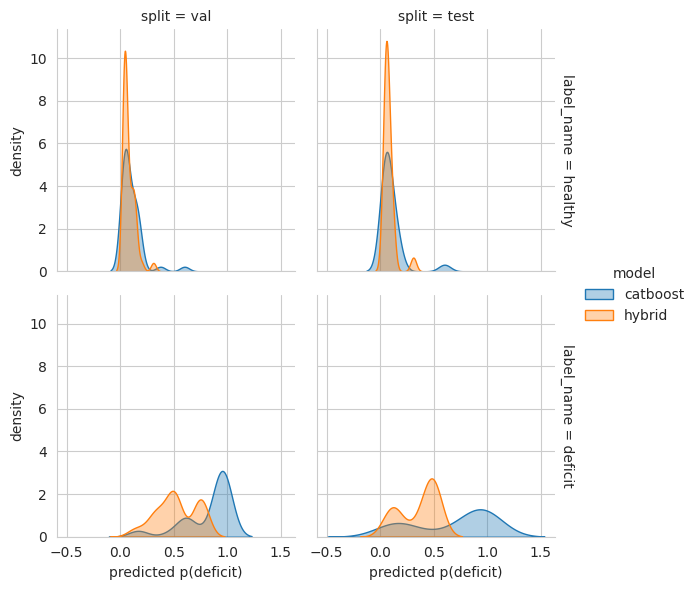

In [76]:
# Score density by label/model across splits
rows = []
for split in splits:
    for model in models:
        for score, label in zip(probs[model][split], labels[split]):
            rows.append({'split': split, 'model': model, 'score': float(score), 'label': int(label)})

dist_df = pd.DataFrame(rows)
dist_df['label_name'] = dist_df['label'].map({0: 'healthy', 1: 'deficit'})

g = sns.FacetGrid(dist_df, row='label_name', col='split', hue='model', margin_titles=True, height=3)
g.map(sns.kdeplot, 'score', fill=True, common_norm=False, alpha=0.35, bw_adjust=0.9)
g.add_legend(title='model')
g.set_axis_labels('predicted p(deficit)', 'density')
plt.show()

## Phenology (NDVI trajectory over time)

We now show crop NDVI through the 5 seasonal windows with clearer context: mean ±1 std for healthy vs deficit across train/val/test. This makes it easy to see when the canopy diverges between classes and whether the pattern is consistent across splits.

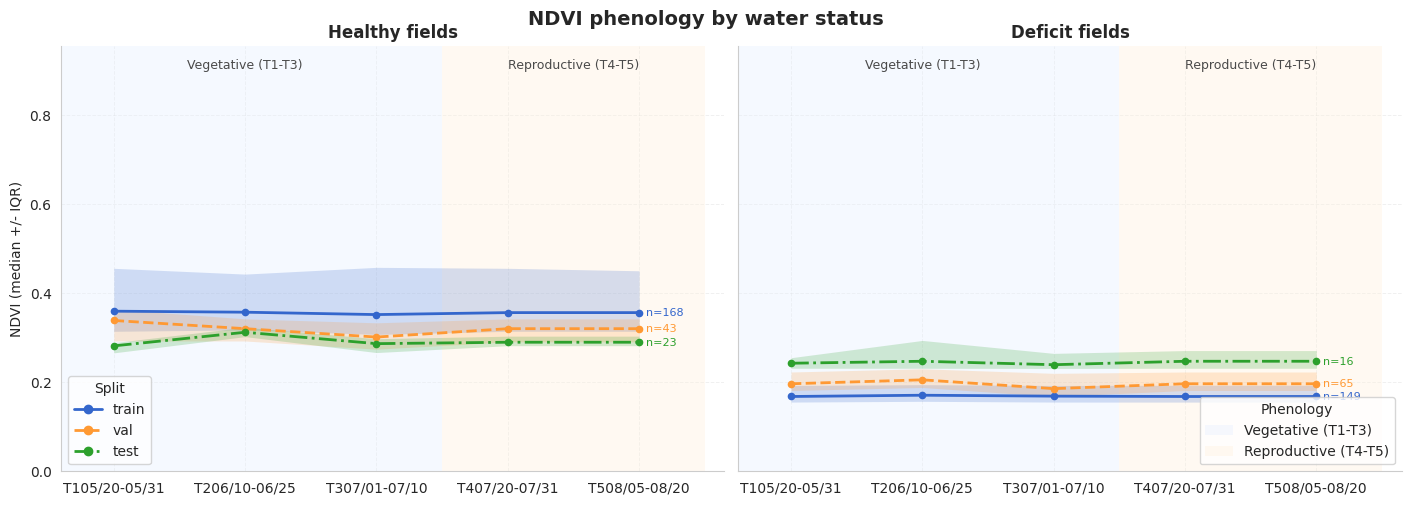

In [77]:
# NDVI phenology (styled: healthy vs deficit across train/val/test)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from src.config import get_season_windows_for_crop, TARGET_CROP

phen_splits = ['train', 'val', 'test']
ndvi_ts = {split: np.load(INTERIM / f'ndvi_ts_{split}.npy') for split in phen_splits}
label_files = {
    'train': 'y_train_deficit_label.npy',
    'val': 'y_val_deficit_label.npy',
    'test': 'y_test_deficit_label.npy',
}
labels_all = {split: np.load(INTERIM / fname) for split, fname in label_files.items()}

time_windows = get_season_windows_for_crop(TARGET_CROP)
time_labels = [f"T{i+1}{m1:02d}/{d1:02d}-{m2:02d}/{d2:02d}" for i, (m1, d1, m2, d2) in enumerate(time_windows)]
T = len(time_labels)

label_names = {0: 'healthy', 1: 'deficit'}
split_style = {
    'train': dict(color='#3366cc', linestyle='-'),
    'val': dict(color='#ff9933', linestyle='--'),
    'test': dict(color='#2ca02c', linestyle='-.')
}

phase_spans = [
    ('Vegetative (T1-T3)', (-0.5, 2.5), '#e8f0ff'),
    ('Reproductive (T4-T5)', (2.5, 4.5), '#fff2e0')
]

def summarize(arr):
    med = np.nanmedian(arr, axis=0)
    q1 = np.nanpercentile(arr, 25, axis=0)
    q3 = np.nanpercentile(arr, 75, axis=0)
    return med, q1, q3

def finite_max(arr):
    arr = np.where(arr == 0, np.nan, arr)
    vals = arr[np.isfinite(arr)]
    return vals.max() if vals.size else np.nan

split_max = [finite_max(v) for v in ndvi_ts.values()]
split_max = [m for m in split_max if np.isfinite(m)]
ndvi_global_max = max(split_max) if split_max else 1.0
ymax = ndvi_global_max * 1.08

fig, axes = plt.subplots(1, 2, figsize=(14, 4.8), sharey=True, constrained_layout=True)
xs = np.arange(T)
for ax, label_val in zip(axes, [0, 1]):
    for name, span, color in phase_spans:
        ax.axvspan(span[0], span[1], color=color, alpha=0.4, lw=0)
        ax.text(np.mean(span), ymax * 0.97, name, ha='center', va='top', fontsize=9, color='#4a4a4a')

    for split in phen_splits:
        ts = np.where(ndvi_ts[split] == 0, np.nan, ndvi_ts[split])
        y = labels_all[split]
        mask = y == label_val
        if mask.sum() == 0:
            continue
        med, q1, q3 = summarize(ts[mask])
        style = split_style[split]
        ax.plot(xs, med, marker='o', markersize=4.5, lw=2, label=split, **style)
        ax.fill_between(xs, q1, q3, color=style['color'], alpha=0.2, linewidth=0)
        if not np.isnan(med[-1]):
            ax.text(xs[-1] + 0.05, med[-1], f"n={mask.sum()}", color=style['color'], fontsize=8, ha='left', va='center')

    ax.set_title(f"{label_names[label_val].title()} fields", fontsize=12, fontweight='bold')
    ax.set_xticks(range(T))
    ax.set_xticklabels(time_labels)
    ax.set_ylim(0, ymax)
    ax.set_xlim(-0.4, T - 0.35)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('NDVI (median +/- IQR)')
split_handles = [
    Line2D([0], [0], color=style['color'], lw=2, linestyle=style['linestyle'], marker='o', label=split)
    for split, style in split_style.items()
]
phase_handles = [Patch(facecolor=color, alpha=0.4, label=name, edgecolor='none') for name, _, color in phase_spans]
axes[0].legend(handles=split_handles, title='Split', loc='lower left')
axes[1].legend(handles=phase_handles, title='Phenology', loc='lower right')
fig.suptitle('NDVI phenology by water status', fontsize=14, fontweight='bold', y=1.02)
plt.show()


## Quantitative comparison

The table compares CatBoost and Hybrid on val/test. Metrics use the shared decision threshold (`tau` from the hybrid calibration) so both models are evaluated at the same operating point.

In [78]:
rows = []
for split in splits:
    y_true = labels[split]
    for model in models:
        scores = probs[model][split]
        rows.append({
            'split': split, 'model': model,
            'roc_auc': roc_auc_score(y_true, scores),
            'ap': average_precision_score(y_true, scores),
            'precision_at_tau': precision_score(y_true, scores >= tau, zero_division=0),
            'recall_at_tau': recall_score(y_true, scores >= tau, zero_division=0),
            'f1_at_tau': f1_score(y_true, scores >= tau, zero_division=0),
        })

table = pd.DataFrame(rows).set_index(['split', 'model']).round(3)
table

roc_auc     ap  precision_at_tau  recall_at_tau  f1_at_tau
split model                                                               
val   catboost    0.992  0.994             0.968          0.938      0.953
      hybrid      0.992  0.995             0.983          0.892      0.935
test  catboost    0.961  0.946             0.917          0.688      0.786
      hybrid      0.965  0.954             0.909          0.625      0.741

## Optional: quantile ablation
You can rerun `prepare_dataset` with a different `NDRE_DEFICIT_Q` and reload metrics to compare class rates and AUC/AP. Keep the train/val/test split fixed and avoid tuning on test.